# <a id='toc1_'></a>[journals](#toc0_)
In this notebook, a 'journals' table was created for the database, including various information about the journals and some statistical data obtained from SJR.

INDEX

In [2]:
# Libraries
import pandas as pd

# Countries
import pycountry

# Functions
import sys
sys.path.append('../src')
from support_transform import *
from support_clean import *

### <a id='toc1_1_1_'></a>[Open the documents](#toc0_)

In [2]:
for year in range(2010, 2023):
    df_name = f'ii_{year}'
    file_name = f'../data/scimago/scimagojr_{year}.csv'
    globals()[df_name] = pd.read_csv(file_name, sep = ';')
    
df_journal_info = pd.read_csv('../data/journals/journal_info.csv')

### <a id='toc1_1_2_'></a>[Create a table of journals with the journals of this list](#toc0_)

In [3]:
journal_info = df_journal_info.copy()
display(len(journal_info))
journal_info.head(2)

112

,journal_name,num_articles,num_pages
0,Frontiers of Neurology and Neuroscience,325,33
1,PLoS Biology,4651,466


### <a id='toc1_1_3_'></a>[Enrich the table with information from the scimago tables](#toc0_)

In [4]:
# Example of scimago table:
ii_2010.head(2)

,Rank,Sourceid,Title,Type,Issn,SJR,SJR Quartile,H index,Total Docs. (2010),Total Docs. (3years),...,Total Cites (3years),Citable Docs. (3years),Cites / Doc. (2years),Ref. / Doc.,Country,Region,Publisher,Coverage,Categories,Areas
0,1,14181,Annual Review of Neuroscience,journal,"0147006X, 15454126","25,551",Q1,256,20,63,...,2130,63,"29,51","154,05",United States,Northern America,Annual Reviews Inc.,1978-2022,Neuroscience (miscellaneous) (Q1),Neuroscience
1,2,17436,Nature Neuroscience,journal,"10976256, 15461726","11,165",Q1,460,282,811,...,10070,755,"11,51","33,98",United Kingdom,Western Europe,Nature Publishing Group,1998-2022,Neuroscience (miscellaneous) (Q1),Neuroscience


#### <a id='toc1_1_3_1_'></a>[Enrich with the info of the Journals](#toc0_)

In [25]:
cols = ['Title', 'Country', 'Region', 'Publisher', 'Coverage', 'Categories', 'Areas']

journal_list = pd.concat([ii_2010[cols],
                          ii_2011[cols],
                          ii_2012[cols],
                          ii_2013[cols],
                          ii_2014[cols],
                          ii_2015[cols],
                          ii_2016[cols],
                          ii_2017[cols],
                          ii_2018[cols],
                          ii_2019[cols],
                          ii_2020[cols],
                          ii_2021[cols],
                          ii_2022[cols]])

In [6]:
journal_list = journal_list.drop_duplicates()
len(journal_list)

585

In [7]:
columns_once = ['Country', 'Region', 'Publisher', 'Coverage', 'Categories', 'Areas']

journals = pd.merge(journal_info, journal_list[['Title'] + columns_once], left_on='journal_name', right_on='Title', how='left')
journals = journals.drop('Title', axis=1)

journals = journals.drop_duplicates(subset=['journal_name'])
len(journals['journal_name'].unique())

112

#### <a id='toc1_1_3_2_'></a>[Enrich with the stats of the journals [2010 - 2022]](#toc0_)

In [9]:
years = range(2010, 2023)

for year in years:
    df_name = f'ii_{year}'
    
    columns_by_year = ['SJR', 'SJR Quartile', 'H index', f'Total Docs. ({year})']
    columns_new_names = [f'sjr_{year}', f'quartile_{year}', f'hindex_{year}', f'docs_{year}']
    
    if df_name in locals():
        columns_to_add = [col for col in columns_new_names]
        journals = pd.merge(journals, locals()[df_name][['Title'] + columns_by_year], left_on='journal_name', right_on='Title', how='left')
        journals = journals.drop('Title', axis=1)
        journals = journals.rename(columns=dict(zip(columns_by_year, columns_to_add)))

In [21]:
journals.head(2)

,journal_name,num_articles,num_pages,Country,Region,Publisher,Coverage,Categories,Areas,sjr_2010,...,hindex_2020,docs_2020,sjr_2021,quartile_2021,hindex_2021,docs_2021,sjr_2022,quartile_2022,hindex_2022,docs_2022
0,Frontiers of Neurology and Neuroscience,325,33,Switzerland,Western Europe,S. Karger AG,"2005-2019, 2021",Medicine (miscellaneous) (Q2); Neurology (clin...,Medicine; Neuroscience,"0,456",...,32.0,0.0,"0,199",Q4,32.0,14.0,"0,506",Q3,32.0,0.0
1,PLoS Biology,4651,466,United States,Northern America,Public Library of Science,2003-2022,Agricultural and Biological Sciences (miscella...,Agricultural and Biological Sciences; Biochemi...,"7,847",...,293.0,348.0,"3,928",Q1,293.0,337.0,"4,005",Q1,293.0,403.0


### <a id='toc1_1_4_'></a>[Manage NaN Values](#toc0_)

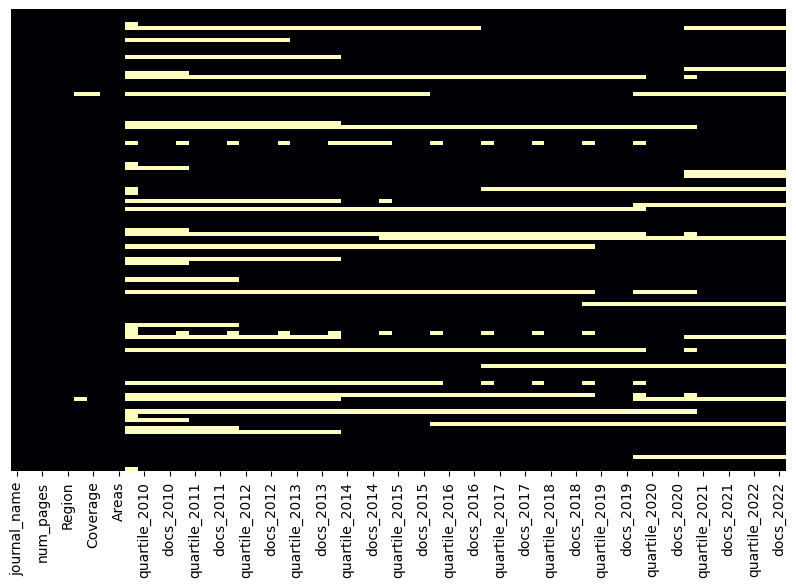

In [29]:
view_nan(journals)

#### <a id='toc1_1_4_1_'></a>[Quartiles](#toc0_)

In [33]:
journals['quartile_2010'].isna().sum()

28

In [34]:
quartile_cols = [f'quartile_{year}' for year in range(2010, 2023)]
journals[quartile_cols] = journals[quartile_cols].fillna('-')

In [35]:
journals['quartile_2010'].isna().sum()

0

#### <a id='toc1_1_4_2_'></a>[rank, docs and other numeric columns](#toc0_)

In [42]:
journals[['sjr_2010', 'hindex_2010', 'docs_2010']].isna().sum()

sjr_2010       37
hindex_2010    28
docs_2010      28
dtype: int64

In [45]:
sjr_cols = [f'sjr_{year}' for year in range(2010, 2023)]
hindex_cols = [f'hindex_{year}' for year in range(2010, 2023)]
docs_cols = [f'docs_{year}' for year in range(2010, 2023)]

numeric_cols = sjr_cols + hindex_cols + docs_cols

journals[numeric_cols] = journals[numeric_cols].fillna(0)

In [46]:
journals[['sjr_2010', 'hindex_2010', 'docs_2010']].isna().sum()

sjr_2010       0
hindex_2010    0
docs_2010      0
dtype: int64

#### <a id='toc1_1_4_3_'></a>[Other NaNs](#toc0_)

In [58]:
journals[['Publisher', 'Coverage']].isna().sum()

Publisher    2
Coverage     1
dtype: int64

In [59]:
cols = ['Publisher', 'Coverage']
journals[cols] = journals[cols].fillna('-')

In [60]:
journals[['Publisher', 'Coverage']].isna().sum()

Publisher    0
Coverage     0
dtype: int64

#### <a id='toc1_1_4_4_'></a>[Check NaN absence](#toc0_)

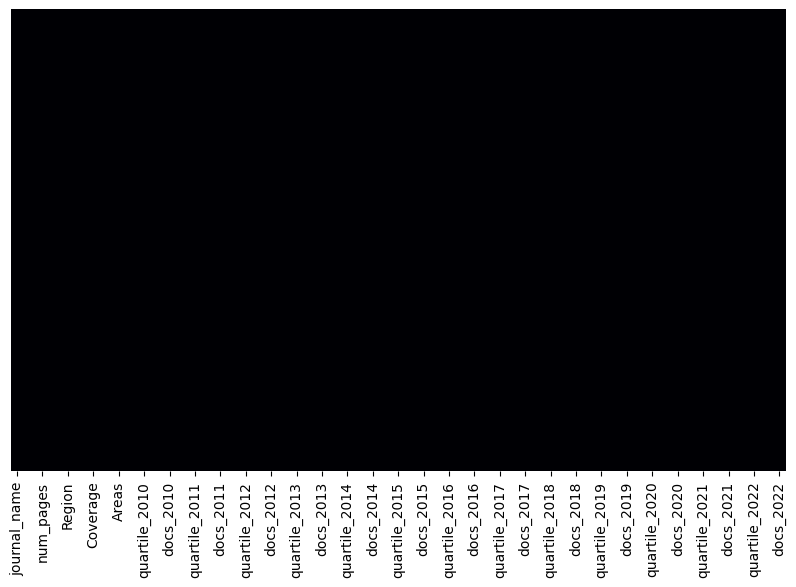

In [61]:
view_nan(journals)

### Include Foreign Key: country_id

In [20]:
countries = pd.read_csv('../data/countries_db.csv', index_col=False)
countries.head(2)

,country_id,country_name,official_state_name,sovereignty,alpha_2_code,alpha_3_code,mln_2010,mln_2011,mln_2012,mln_2013,...,wom_2012,wom_2013,wom_2014,wom_2015,wom_2016,wom_2017,wom_2018,wom_2019,wom_2020,wom_2021
0,4,Afghanistan,The Islamic Republic of Afghanistan,UN member state,AF,AFG,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,248,Åland Islands,Åland,Finland,AX,ALA,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
journal_countries = journals['Country'].unique()
journal_countries

array(['Switzerland', 'United States', 'United Kingdom', 'Poland',
       'China', 'Czech Republic', 'New Zealand', 'India', 'Ireland',
       'Germany', 'Egypt', 'Netherlands', 'United Arab Emirates', 'Italy',
       'Greece', 'South Korea', 'France'], dtype=object)

In [54]:
country_codes_dict = {}

for name in journal_countries:
    country = pycountry.countries.get(name=name)
    if country:
        country_codes_dict[name] = int(country.numeric)
    else:
        country_codes_dict[name] = None

In [59]:
country_codes_dict

{'Switzerland': 756,
 'United States': 840,
 'United Kingdom': 826,
 'Poland': 616,
 'China': 156,
 'Czech Republic': None,
 'New Zealand': 554,
 'India': 356,
 'Ireland': 372,
 'Germany': 276,
 'Egypt': 818,
 'Netherlands': 528,
 'United Arab Emirates': 784,
 'Italy': 380,
 'Greece': 300,
 'South Korea': None,
 'France': 250}

In [47]:
country_codes_dict['Czech Republic'] = 203
country_codes_dict['South Korea'] = 410

In [48]:
country_codes_dict

{'Switzerland': 756,
 'United States': 840,
 'United Kingdom': 826,
 'Poland': 616,
 'China': 156,
 'Czech Republic': 203,
 'New Zealand': 554,
 'India': 356,
 'Ireland': 372,
 'Germany': 276,
 'Egypt': 818,
 'Netherlands': 528,
 'United Arab Emirates': 784,
 'Italy': 380,
 'Greece': 300,
 'South Korea': 410,
 'France': 250}

In [60]:
journals['country_id'] = journals['Country'].map(country_codes_dict)

### Rename columns

In [61]:
old_names = ['Country', 'Region', 'Publisher', 'Coverage', 'Categories', 'Areas']
new_names = ['country', 'region', 'publisher', 'coverage', 'categories', 'areas']

for old, new in zip(old_names, new_names):
    journals = journals.rename(columns={old: new})

### Order columns

In [3]:
# journals = pd.read_csv('../data/journals_db.csv')

In [7]:
journals = journals.rename(columns={'Unnamed: 0': 'journal_id'})

In [13]:
journals = journals[['journal_id', 'country_id', 'journal_name', 'num_articles', 'region', 
                    'publisher', 'coverage', 'categories', 'areas', 
                    'sjr_2010', 'quartile_2010', 'hindex_2010', 'docs_2010', 
                    'sjr_2011', 'quartile_2011', 'hindex_2011', 'docs_2011', 
                    'sjr_2012', 'quartile_2012', 'hindex_2012', 'docs_2012', 
                    'sjr_2013', 'quartile_2013', 'hindex_2013', 'docs_2013', 
                    'sjr_2014', 'quartile_2014', 'hindex_2014', 'docs_2014', 
                    'sjr_2015', 'quartile_2015', 'hindex_2015', 'docs_2015', 
                    'sjr_2016', 'quartile_2016', 'hindex_2016', 'docs_2016', 
                    'sjr_2017', 'quartile_2017', 'hindex_2017', 'docs_2017', 
                    'sjr_2018', 'quartile_2018', 'hindex_2018', 'docs_2018', 
                    'sjr_2019', 'quartile_2019', 'hindex_2019', 'docs_2019', 
                    'sjr_2020', 'quartile_2020', 'hindex_2020', 'docs_2020', 
                    'sjr_2021', 'quartile_2021', 'hindex_2021', 'docs_2021', 
                    'sjr_2022', 'quartile_2022', 'hindex_2022', 'docs_2022']]

### Export the df as .csv

In [15]:
journals.to_csv('../data/journals_db.csv')